In [504]:
import pandas as pd
import numpy as np
import constants

In [36]:
df_weeks = pd.read_pickle('spotify_data/big_boy_df.pkl')
df_weeks = df_weeks.drop_duplicates()
df_api = pd.read_pickle('spotify_data/df_api_needed.pkl')
df_api = df_api.drop_duplicates()
df_api = df_api.drop(columns=['level_0', 'index'])
df_api = df_api.drop_duplicates('spotify_url')
len(df_weeks), len(df_api)

(270399, 9094)

In [37]:
songs_we_care_about = list(set(df_weeks.spotify_url))
df_songs_we_care_about = df_api[df_api.spotify_url.isin(songs_we_care_about)]
df_weeks_we_care_about = df_weeks[df_weeks.ranking.isin(range(50))]

In [562]:
df_SOTA = pd.merge(df_weeks_we_care_about, df_songs_we_care_about, how='left', on='spotify_url')
month = [w.split('-')[1] for w in df_SOTA.week_start]
df_SOTA['month'] = month
df_SOTA.to_pickle('spotify_data/df_SOTA.pkl')

# Monthly
All countries

In [599]:
df_SOTA_temp = df_SOTA
countries = df_SOTA.country.unique()

C = len(countries)
W = len(df_SOTA_temp.month.unique())
S = 49*4
F = 9

X_monthly = np.zeros((C, W, S, F))
y_monthly = []
for i, c in enumerate(countries):
    mask_c = df_SOTA_temp.country==c
    for j, w in enumerate(df_SOTA_temp.month.unique()): 
        mask_w = df_SOTA_temp.month==w
        country_payload = df_SOTA_temp[(mask_c)&(mask_w)].to_numpy()[:S,10:-2]
        X_monthly[i, j] = country_payload
        y_monthly.append(i)
X_monthly = X_monthly.reshape((C*W, -1))
y_monthly = np.asarray(y_monthly)

### Subselection
US, GLOBAL, EG, ES, AU, DE, IE, BR, Colombia, Chile

In [632]:
df_SOTA_temp = df_SOTA
countries = ['global', 'de', 'au', 'eg', 'us', 'es', 'ie', 'br', 'ae', 'cl', 'co']

C = len(countries)
W = len(df_SOTA_temp.month.unique())
S = 49*4
F = 9

X_monthly_subsample = np.zeros((C, W, S, F))
y_monthly_subsample = []
for i, c in enumerate(countries):
    mask_c = df_SOTA_temp.country==c
    for j, w in enumerate(df_SOTA_temp.month.unique()): 
        mask_w = df_SOTA_temp.month==w
        country_payload = df_SOTA_temp[(mask_c)&(mask_w)].to_numpy()[:S,10:-2]
        X_monthly_subsample[i, j] = country_payload
        y_monthly_subsample.append(i)
X_monthly_subsample = X_monthly_subsample.reshape((C*W, -1))
y_monthly_subsample = np.asarray(y_monthly_subsample)
X_monthly_subsample.shape, y_monthly_subsample.shape 

((132, 1764), (132,))

# Weekly
All countries

In [604]:
df_SOTA_temp = df_SOTA#[df_SOTA.week_start==one_week]
countries = df_SOTA.country.unique()

C = len(countries)
W = len(df_SOTA_temp.week_start.unique())
S = 49
F = 9

X_weekly = np.zeros((C, W, S, F))
y_weekly = []
for i, c in enumerate(countries):
    mask_c = df_SOTA_temp.country==c
    for j, w in enumerate(df_SOTA_temp.week_start.unique()): 
        mask_w = df_SOTA_temp.week_start==w
        country_payload = df_SOTA_temp[(mask_c)&(mask_w)].to_numpy()[:,10:-2]
        X_weekly[i, j] = country_payload
        y_weekly.append(i)
X_weekly = X_weekly.reshape((C*W, -1))
y_weekly = np.asarray(y_weekly)

## Beginning of Embedding methods comparison
Code heavily inspired by https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py


In [633]:
X = X_monthly_subsample # Plug in your Sample space
y = y_monthly_subsample # Plug in your Sample labels
n_samples, n_features = X.shape
n_neighbors = 30

In [634]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

def plot_func(payload, title, sample_colors, sample_names):
    one_dim, two_dim = zip(*payload)
    
    fig, ax = plt.subplots(figsize=(20,15))
    ax.scatter(one_dim, two_dim, c=sample_colors)
    ax.set_facecolor('gray')
    for i, txt in enumerate(sample_names):
        ax.annotate(txt, (one_dim[i], two_dim[i]), rotation=20, size=10)

    ax.set_title(title)


In [635]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    try:
        projections[name] = transformer.fit_transform(data, y)
        timing[name] = time() - start_time
    except:
        continue

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...
Computing NCA embedding...


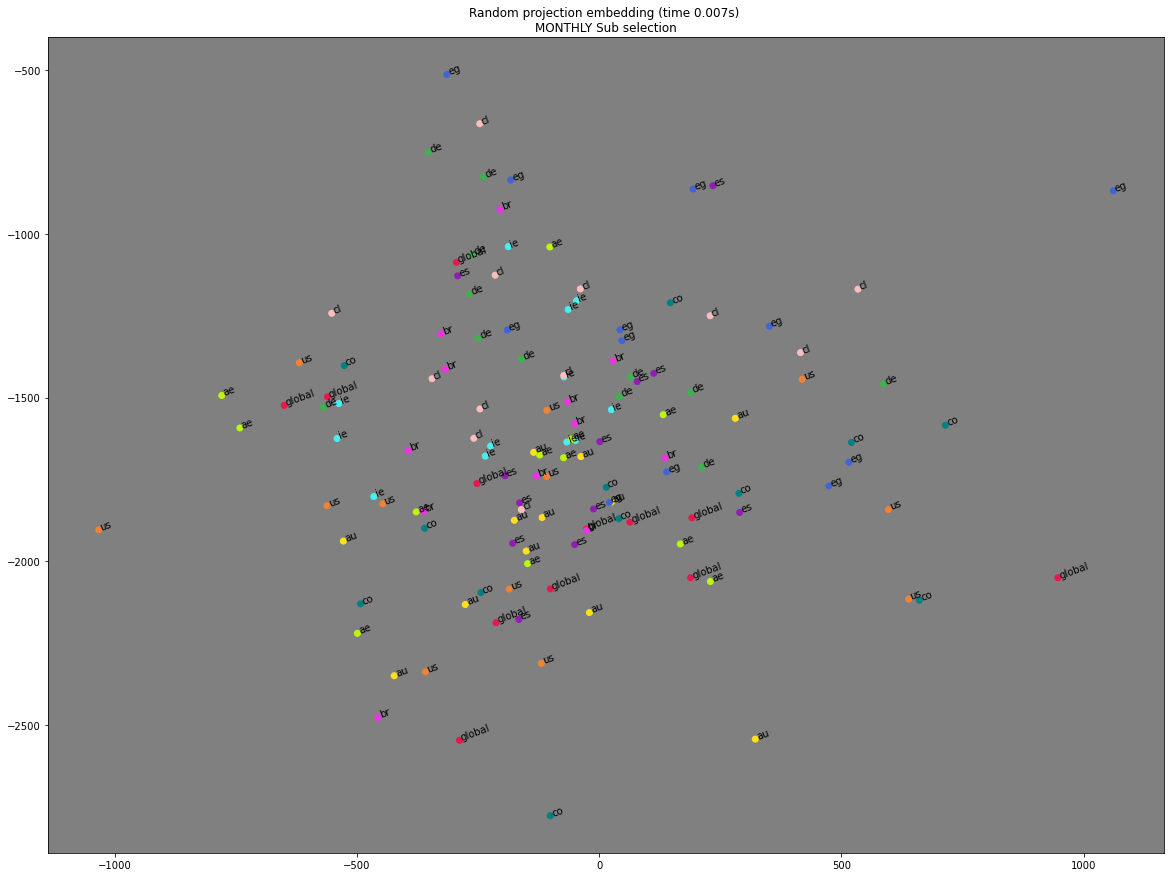

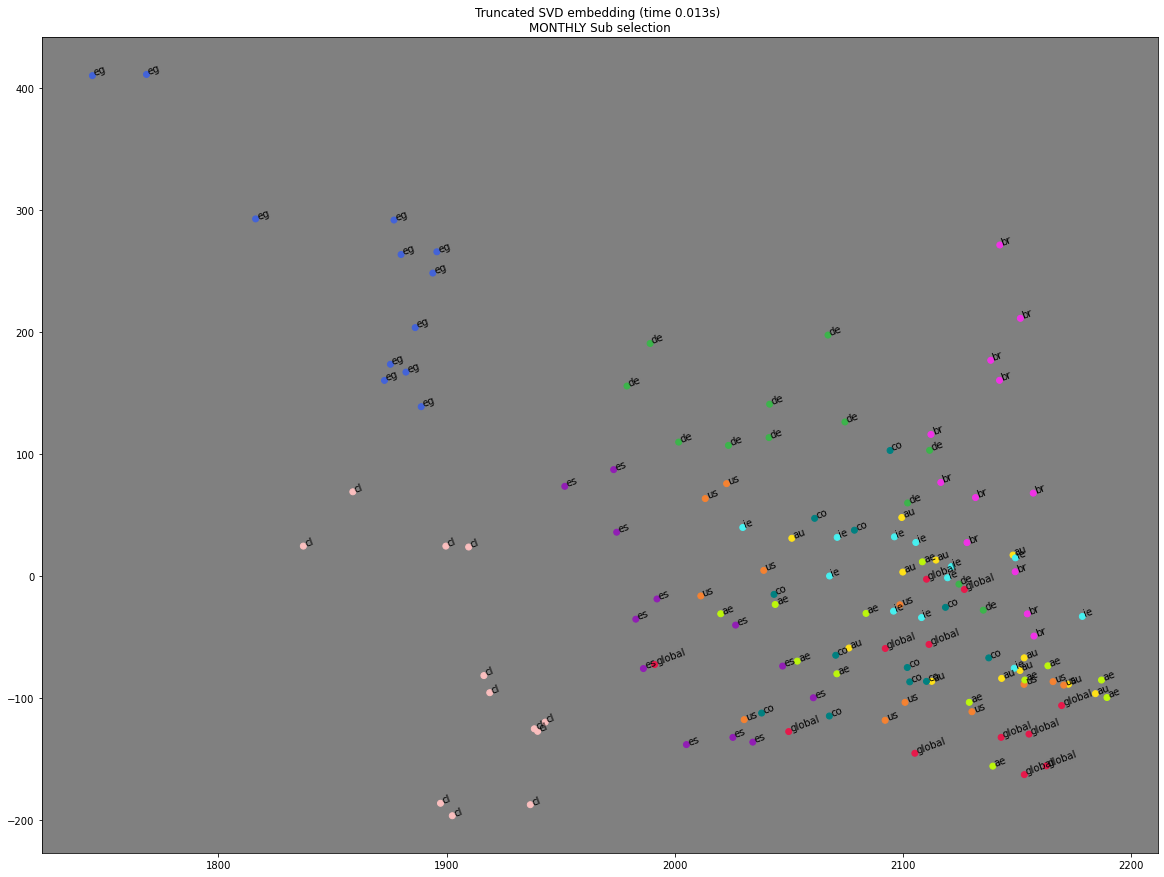

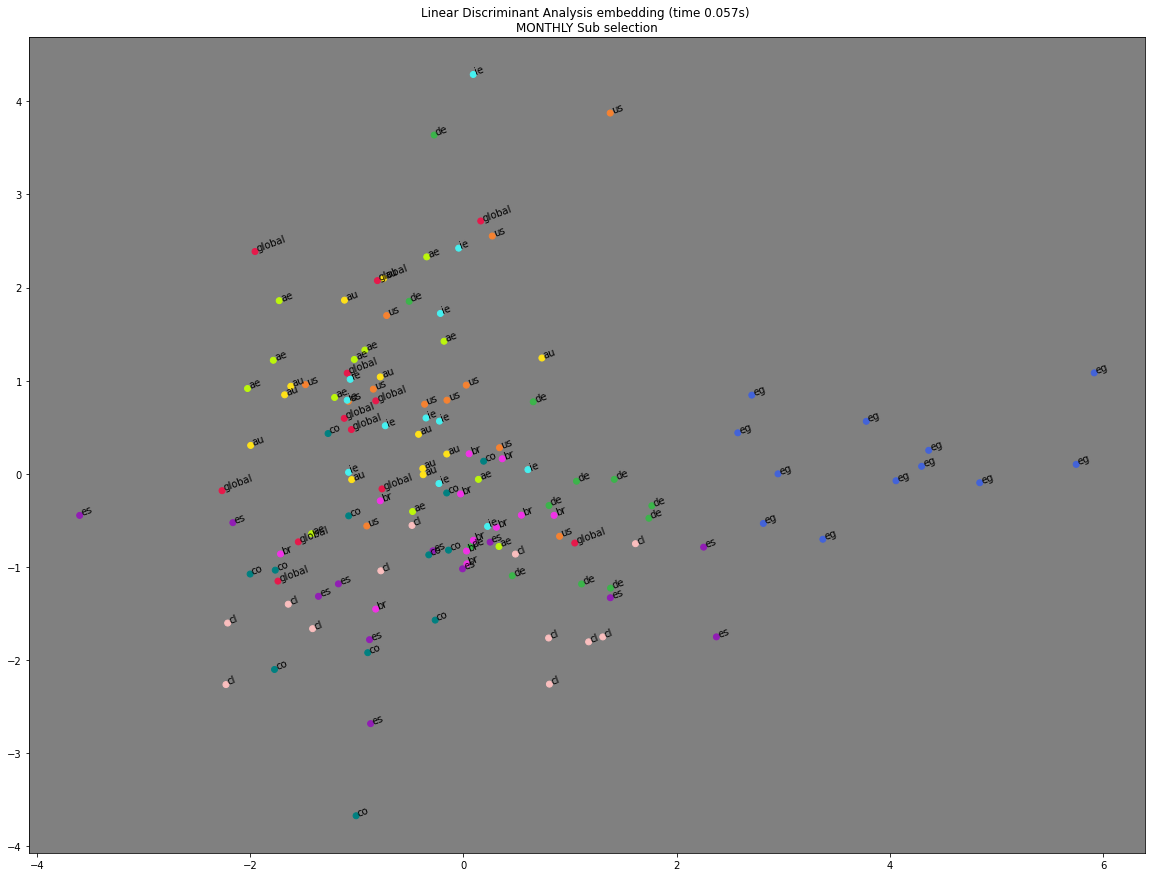

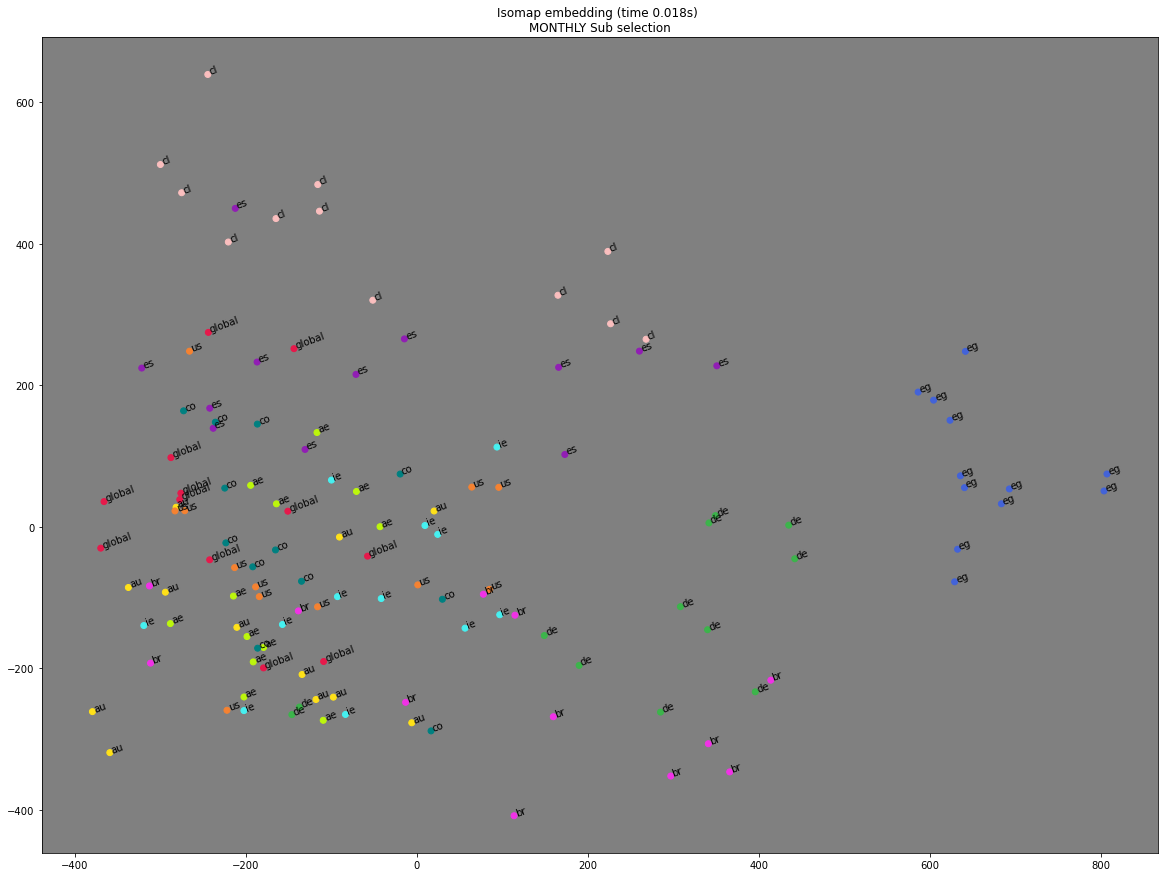

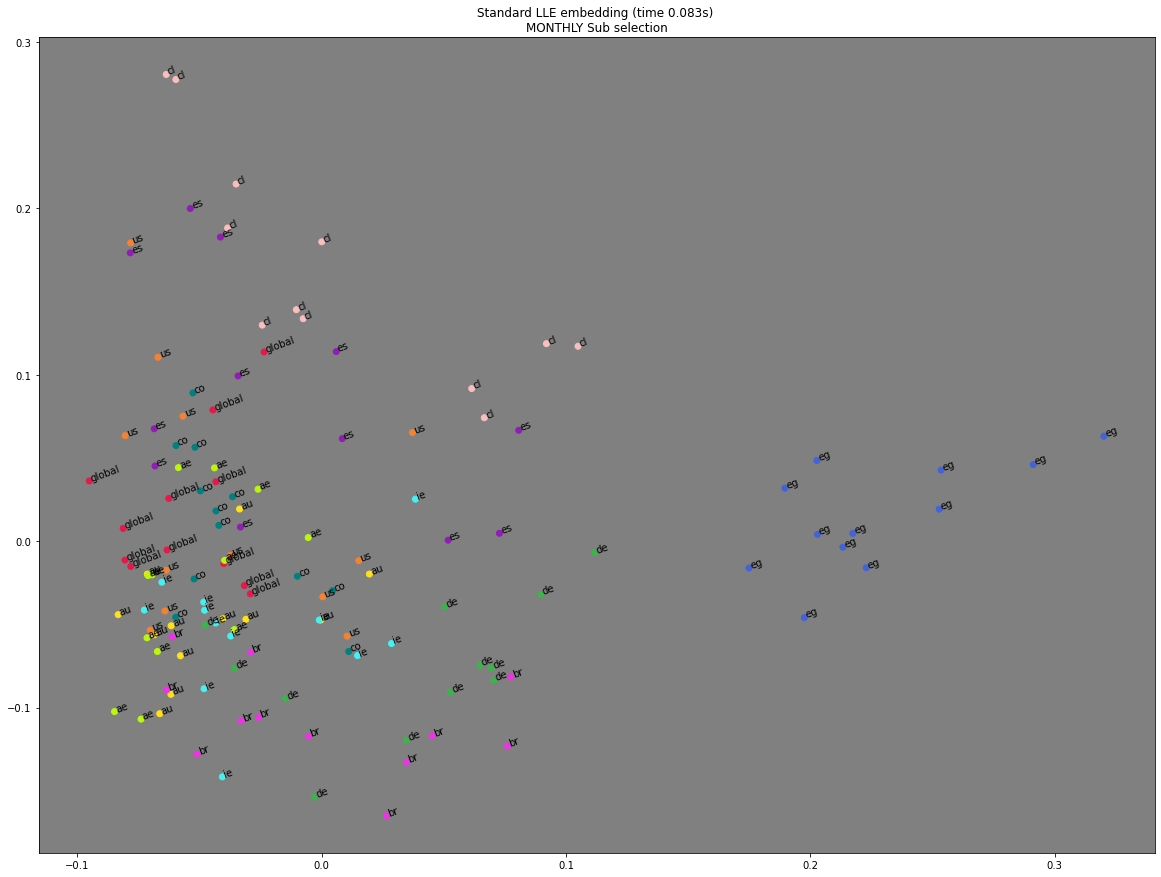

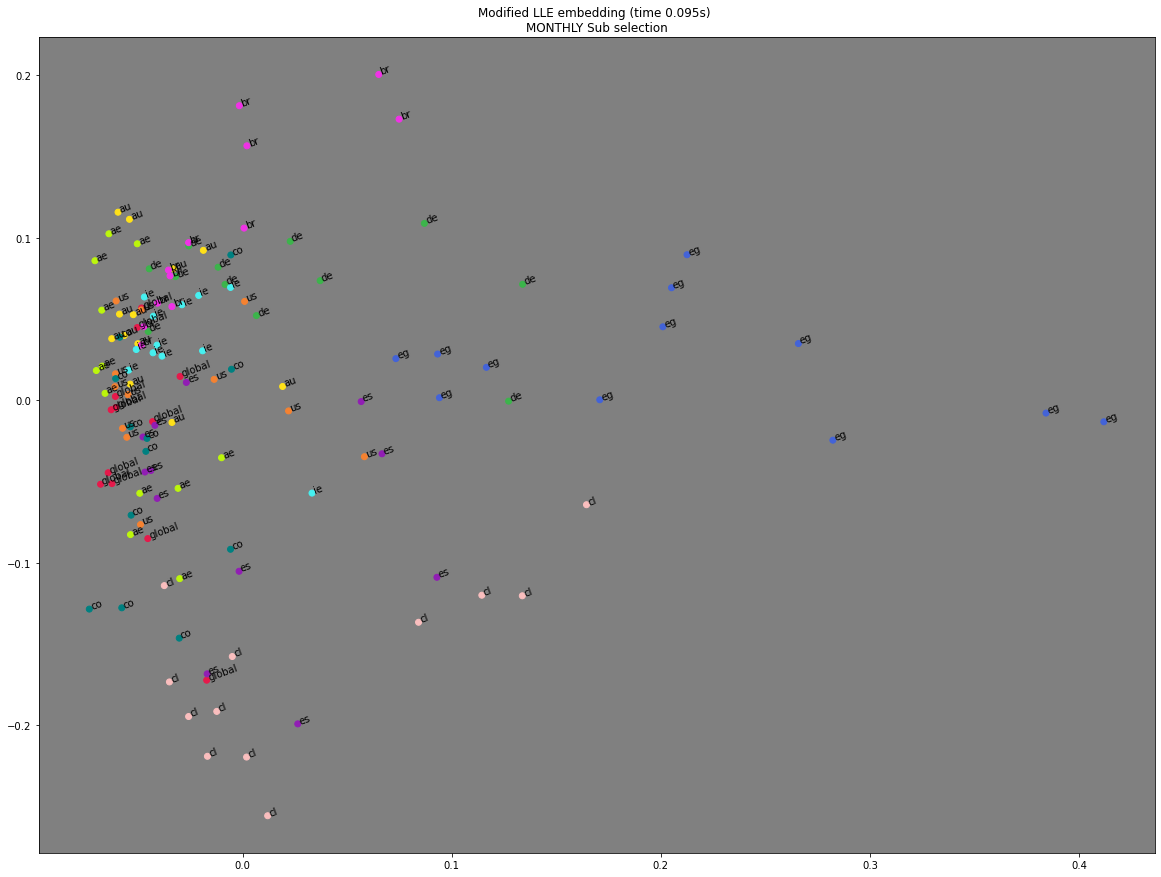

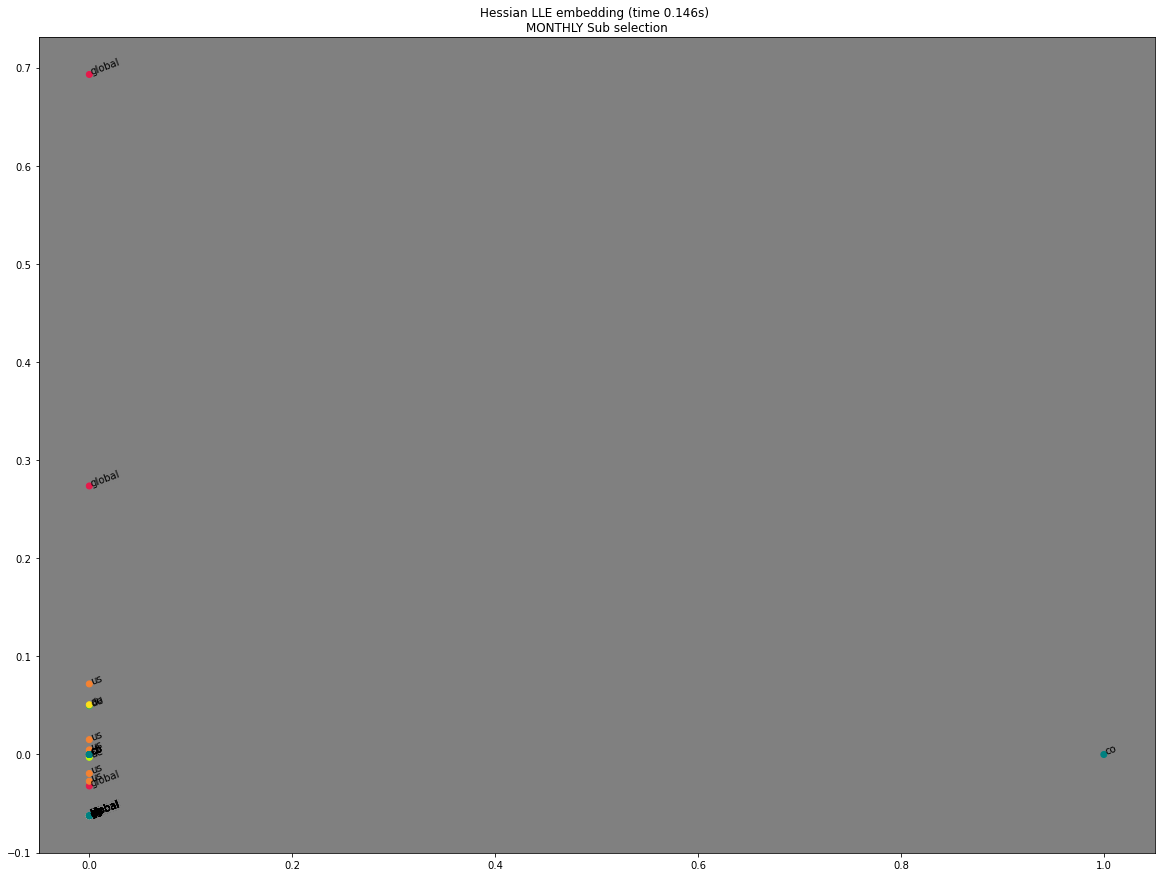

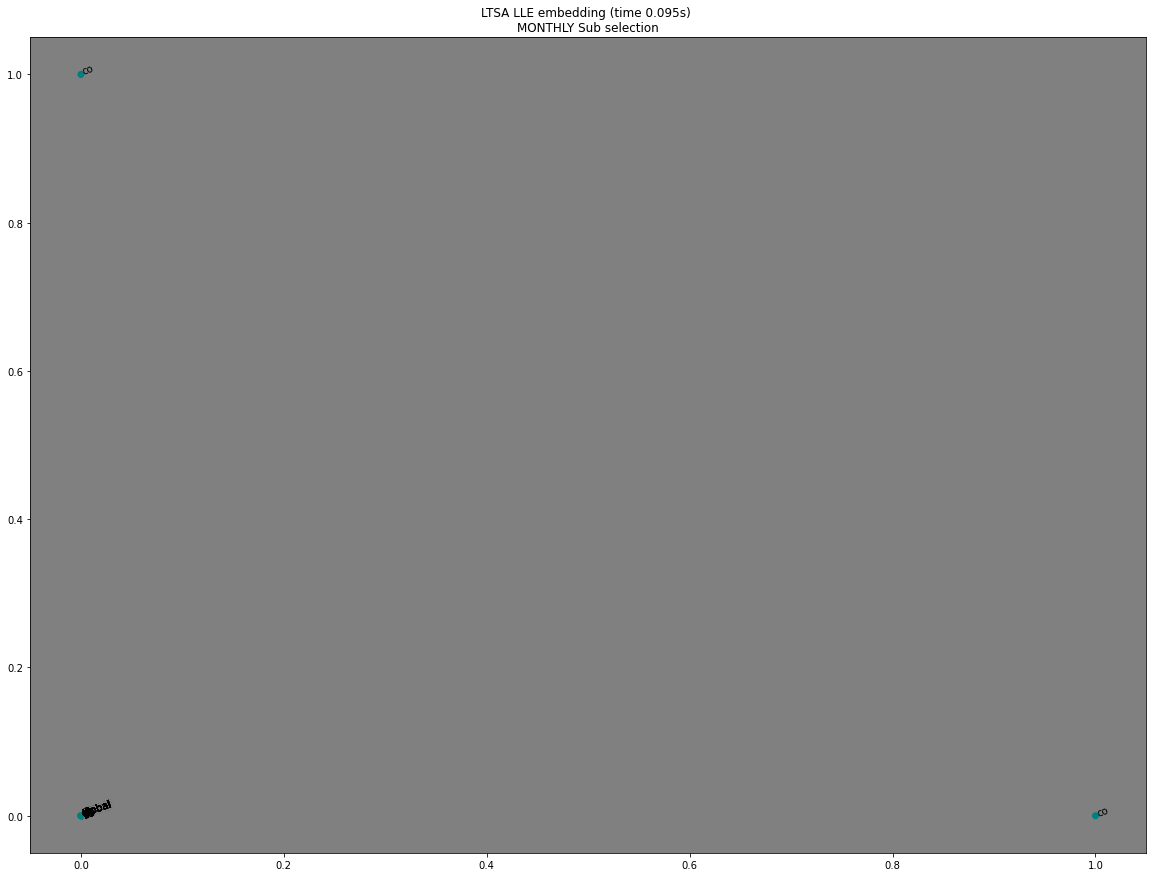

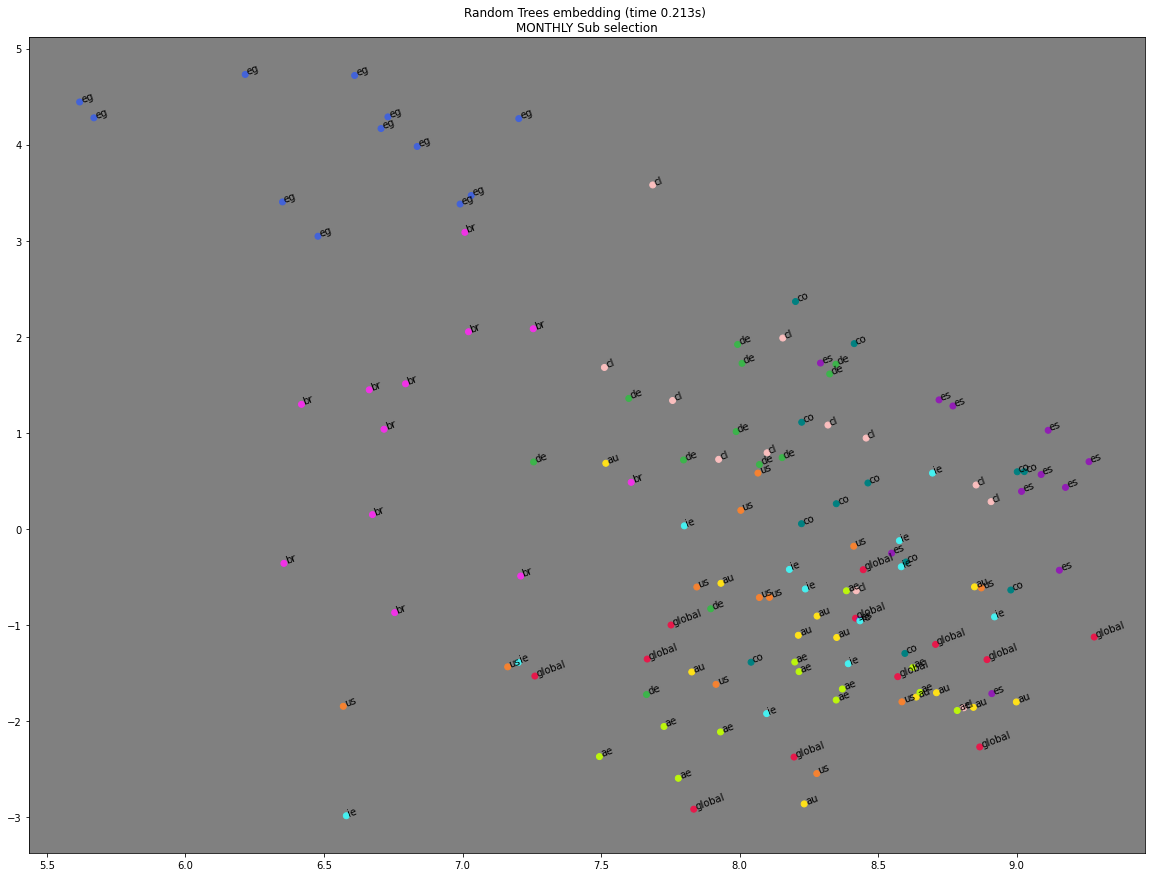

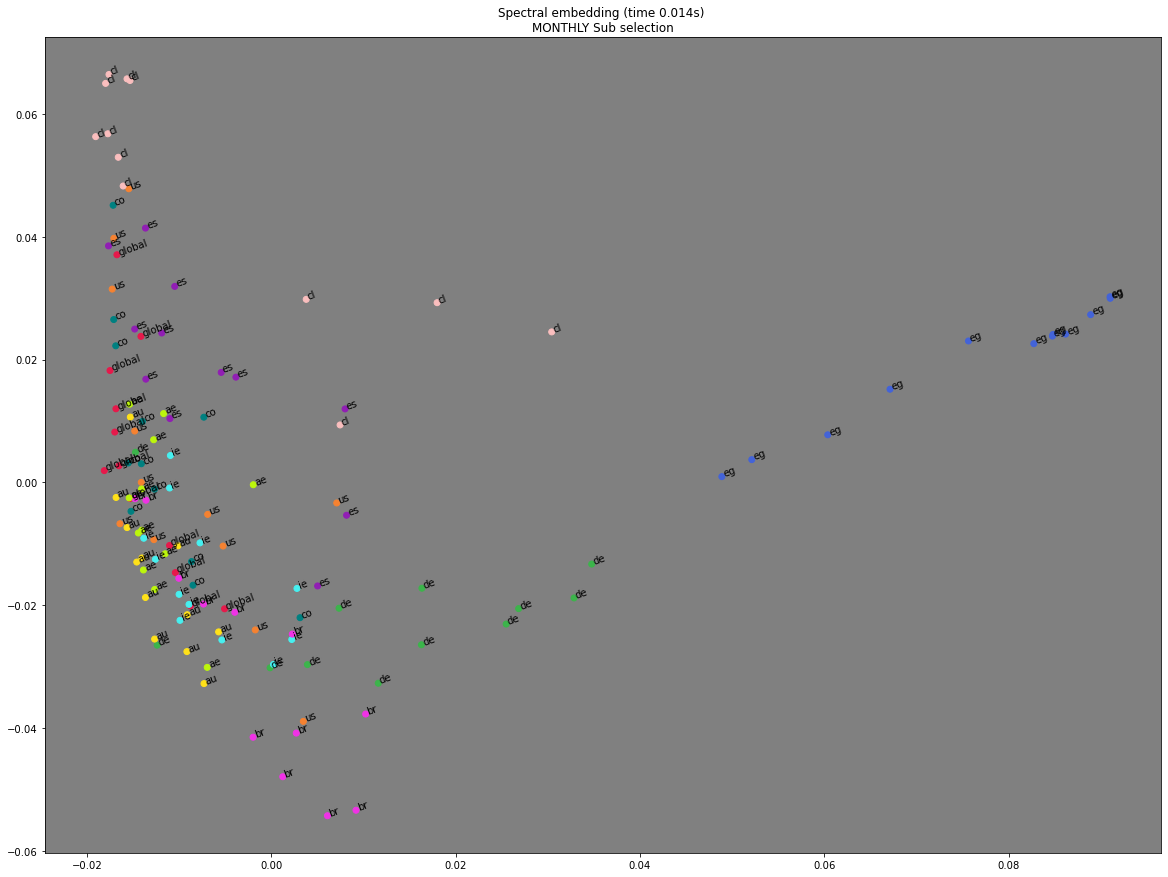

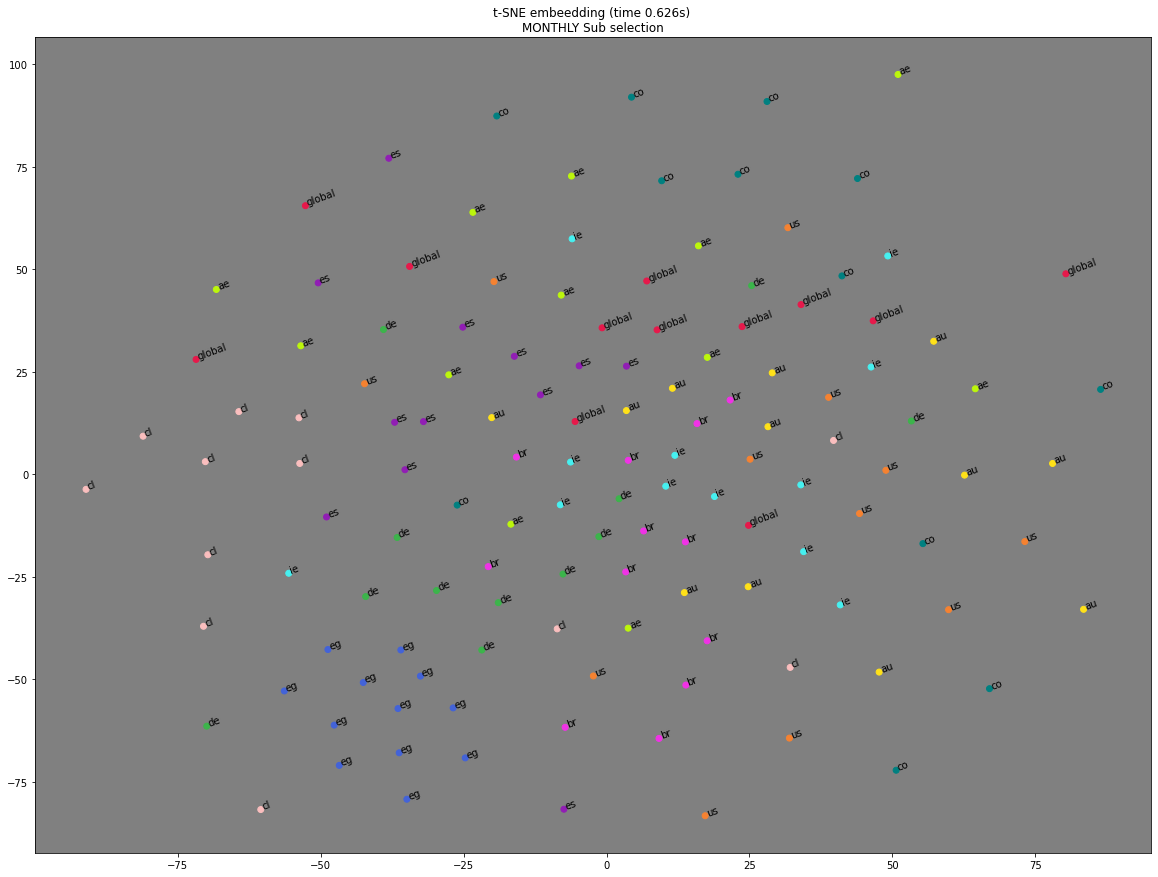

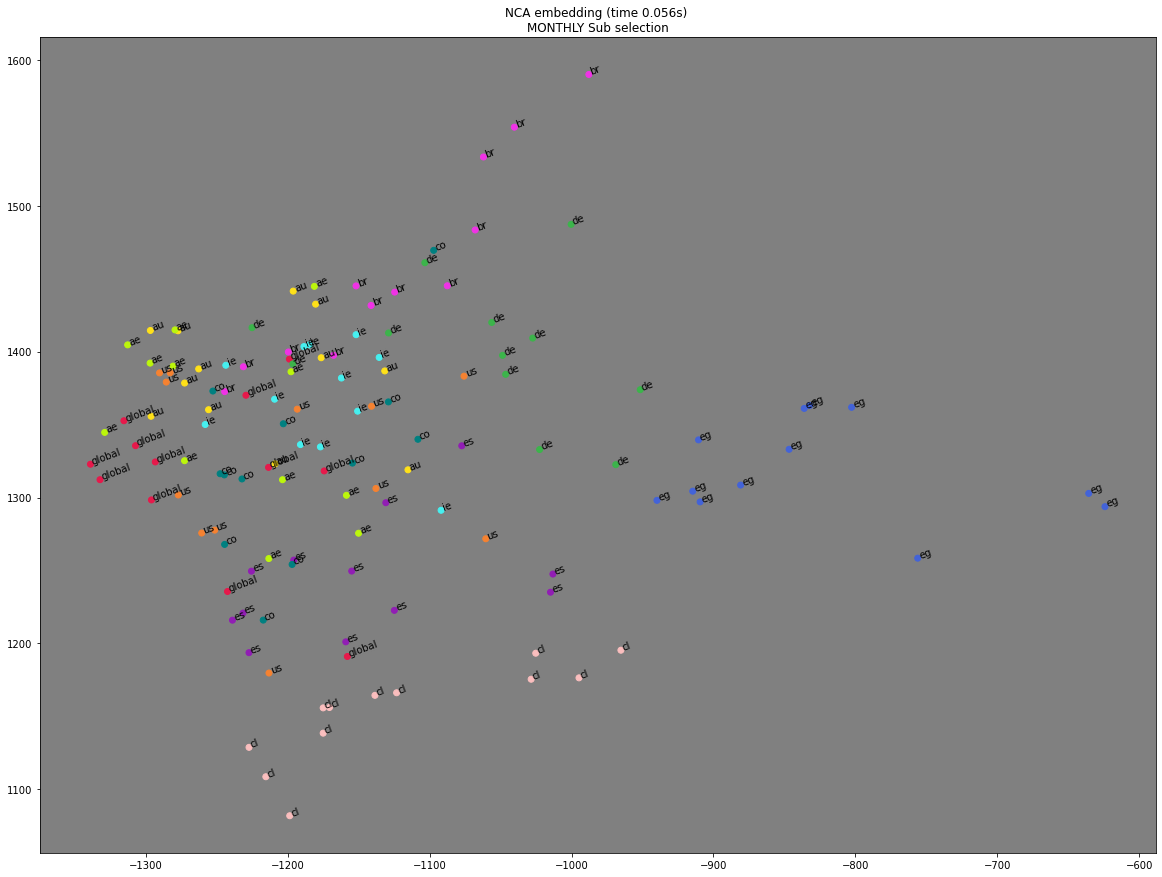

In [636]:
sample_colors, sample_names = zip(*[(constants.COLORS[c], countries[c]) for c in y])
experiment_name = 'MONTHLY Sub selection'
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s) \n{experiment_name}"
    plot_func(projections[name], title, sample_colors, sample_names)

plt.show()

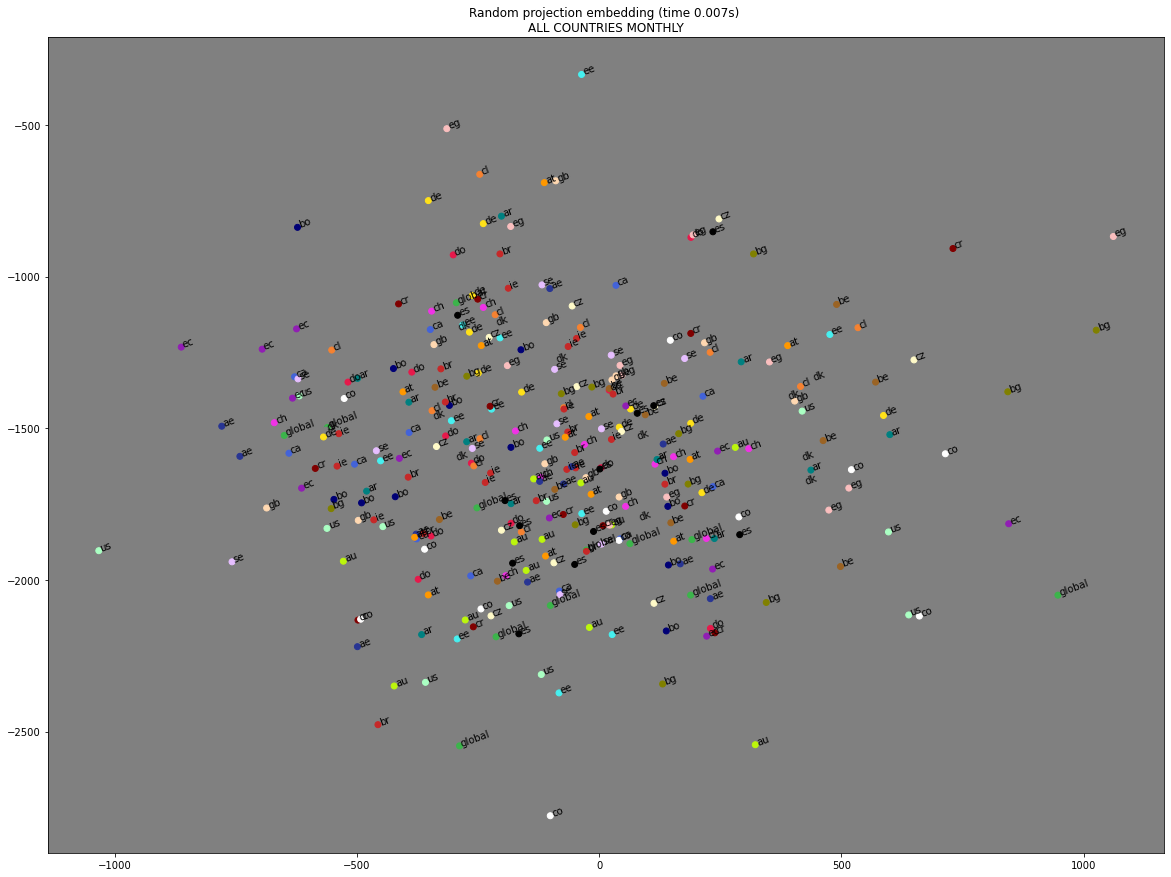

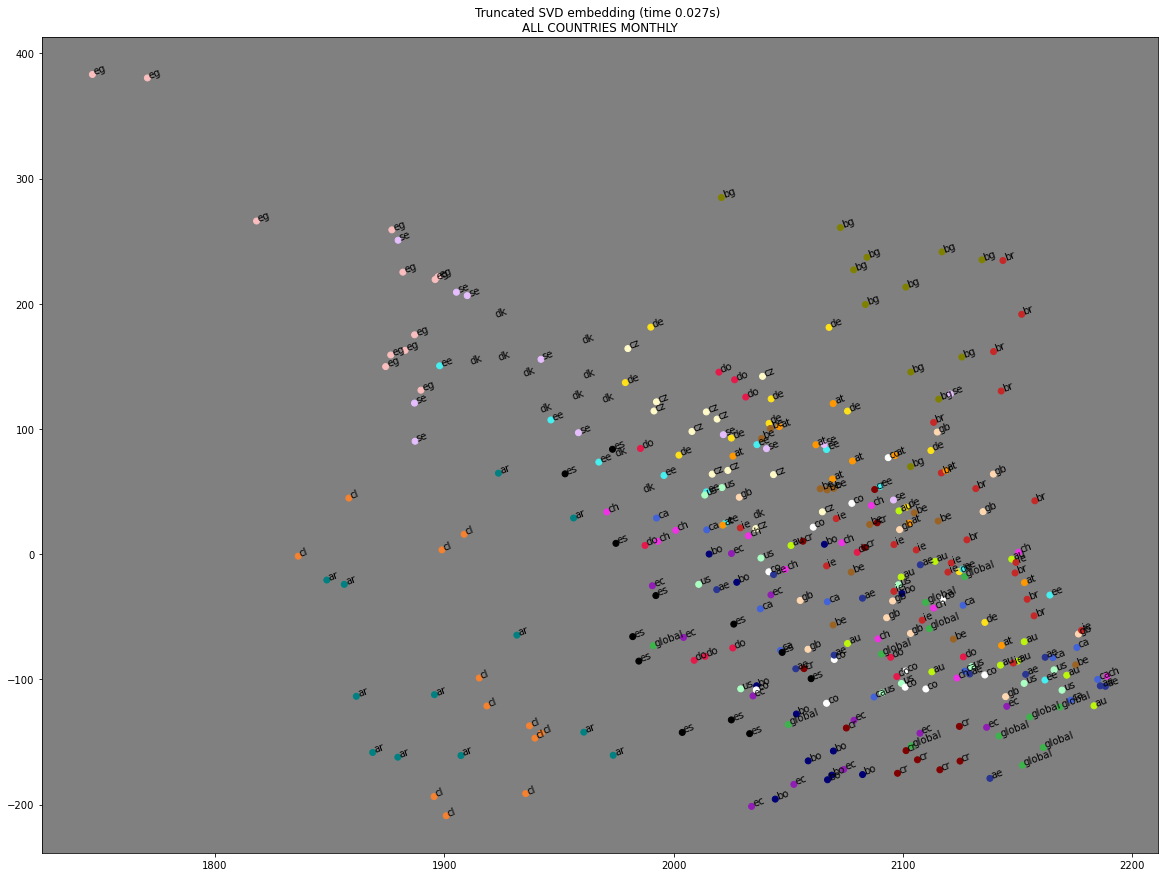

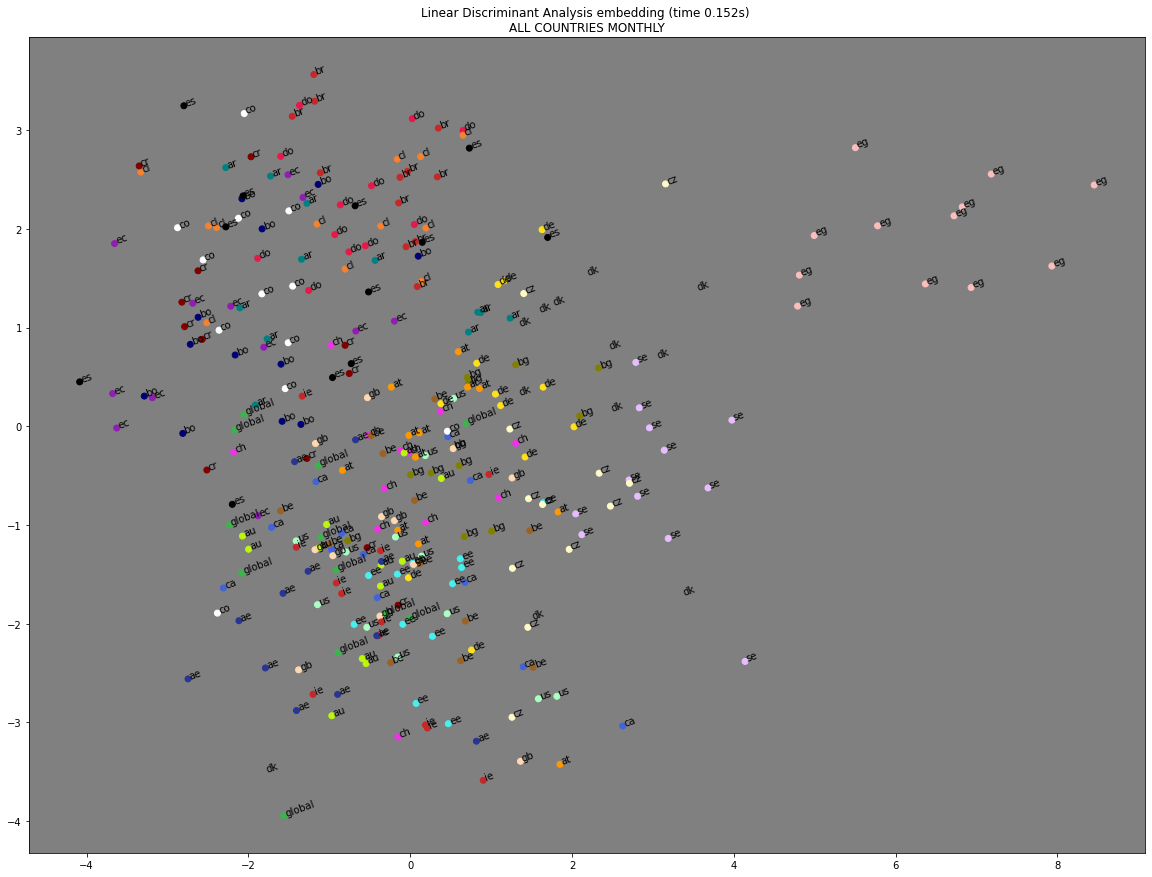

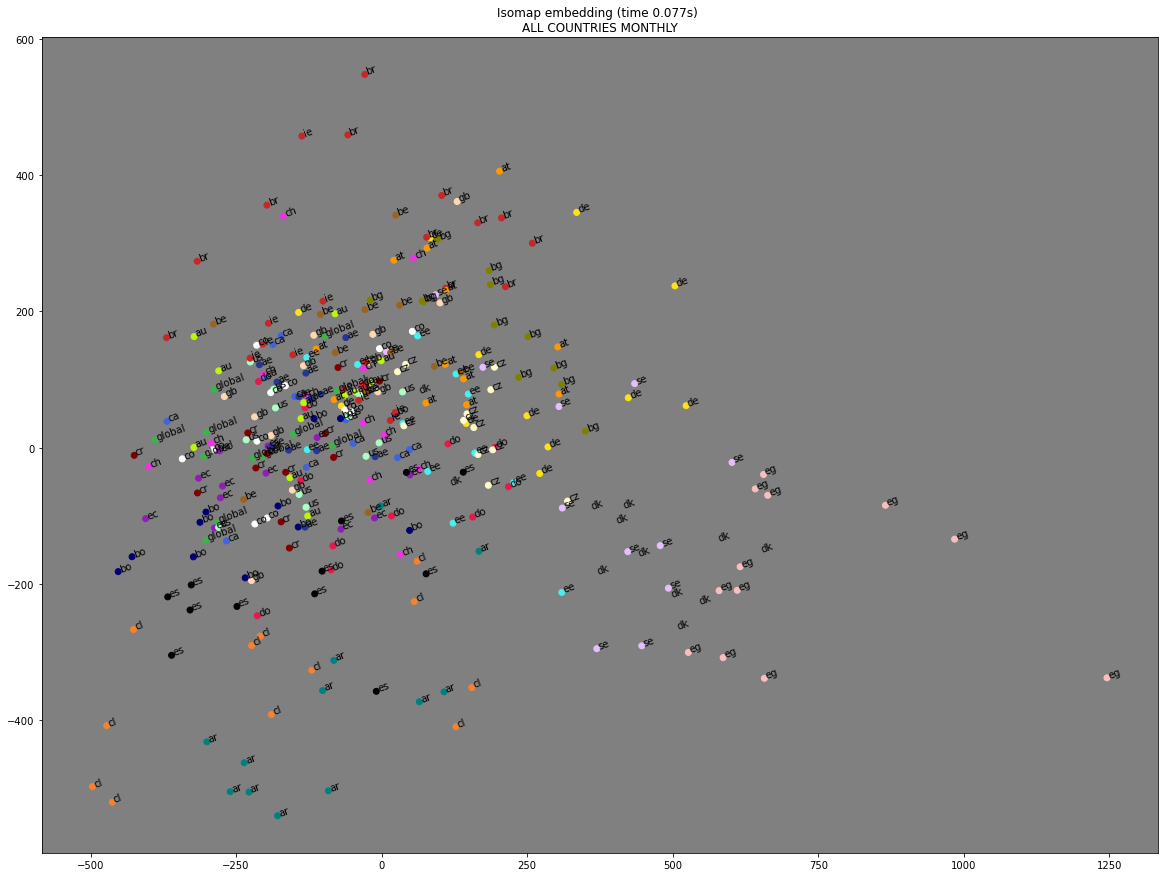

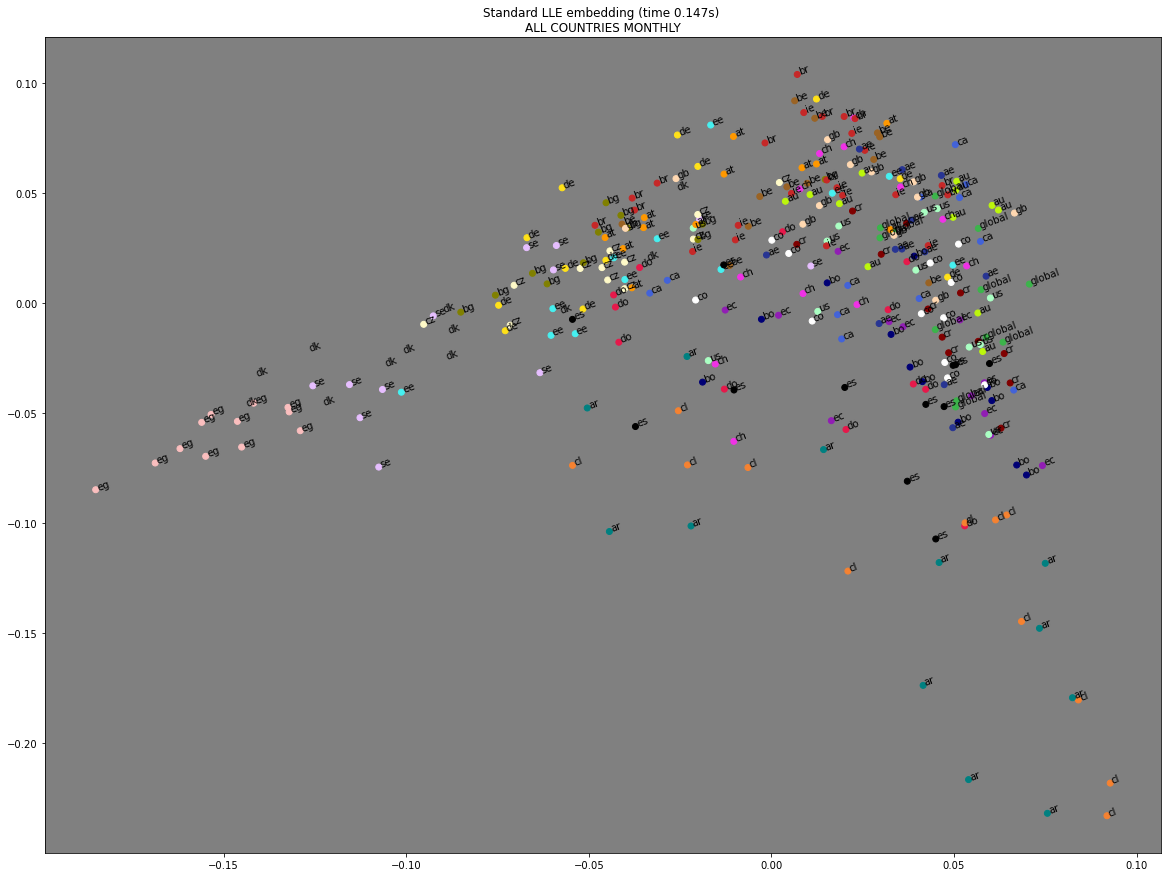

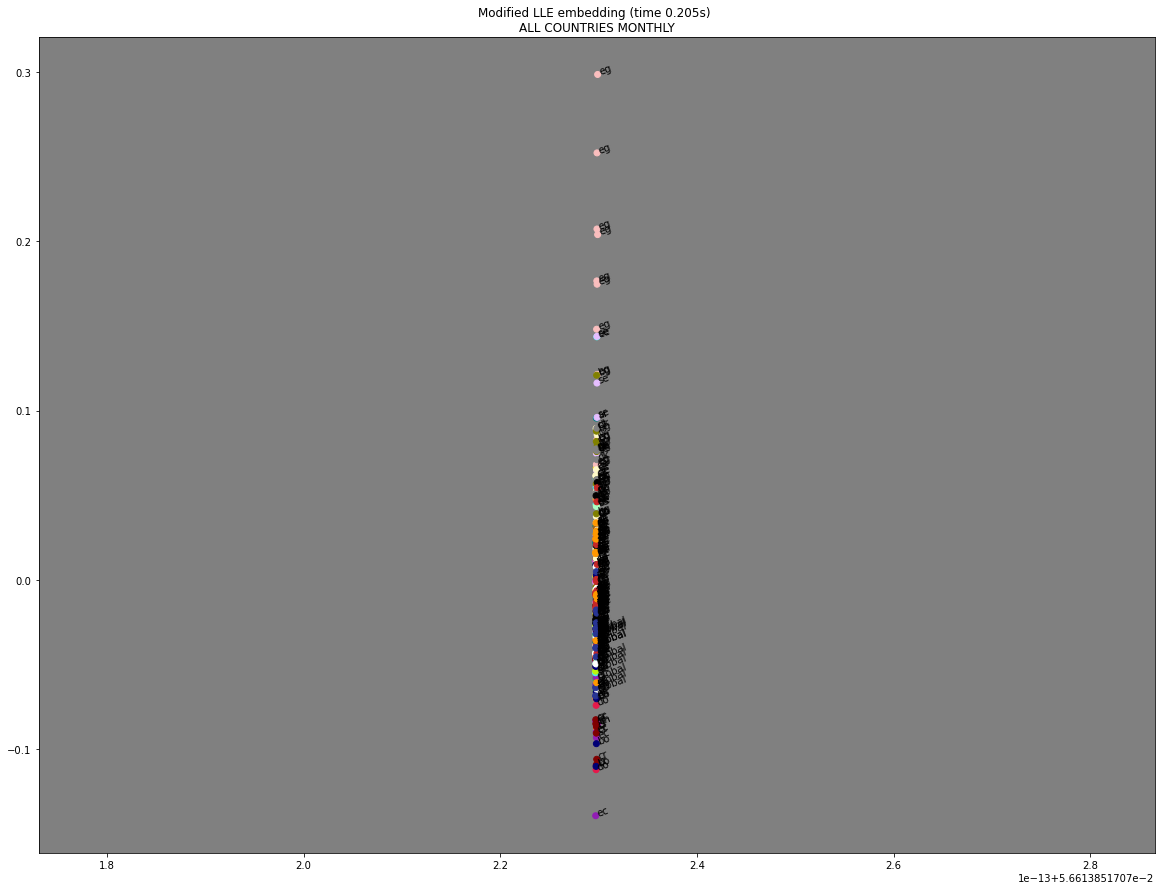

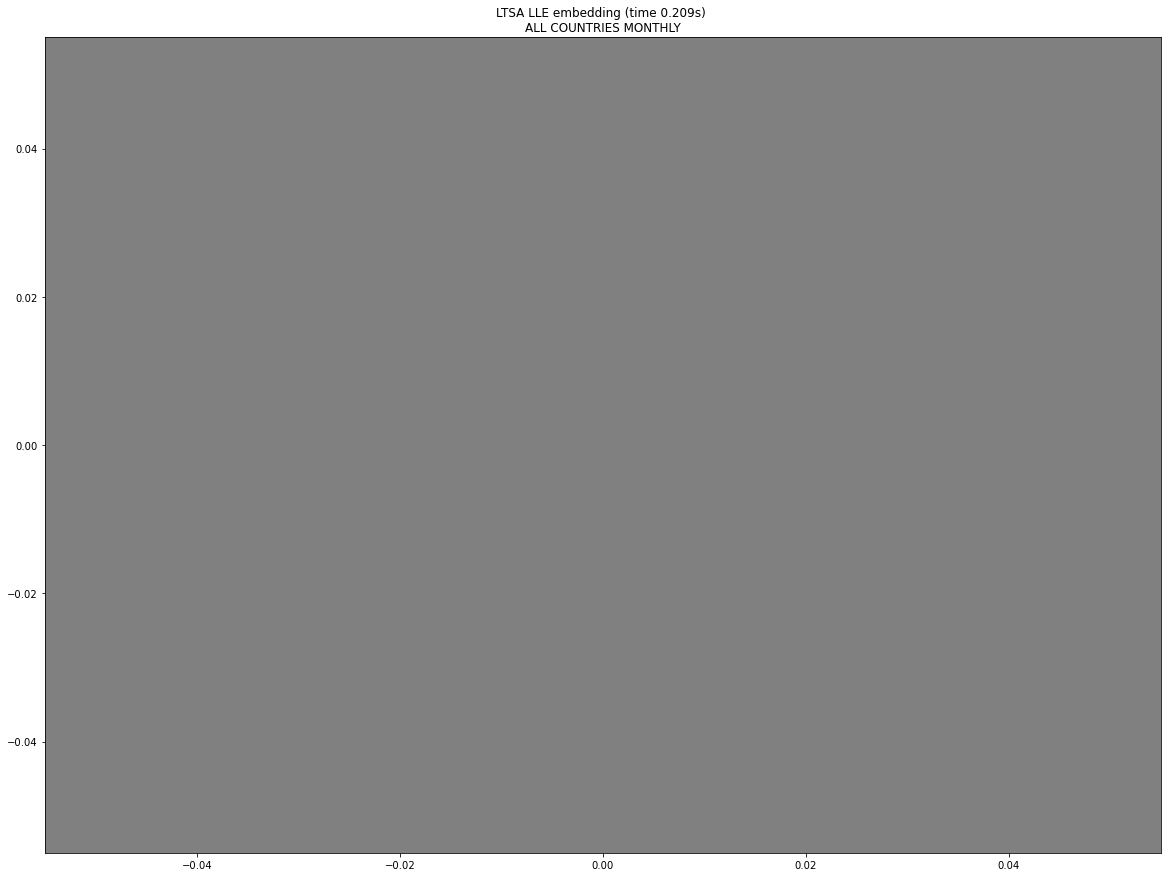

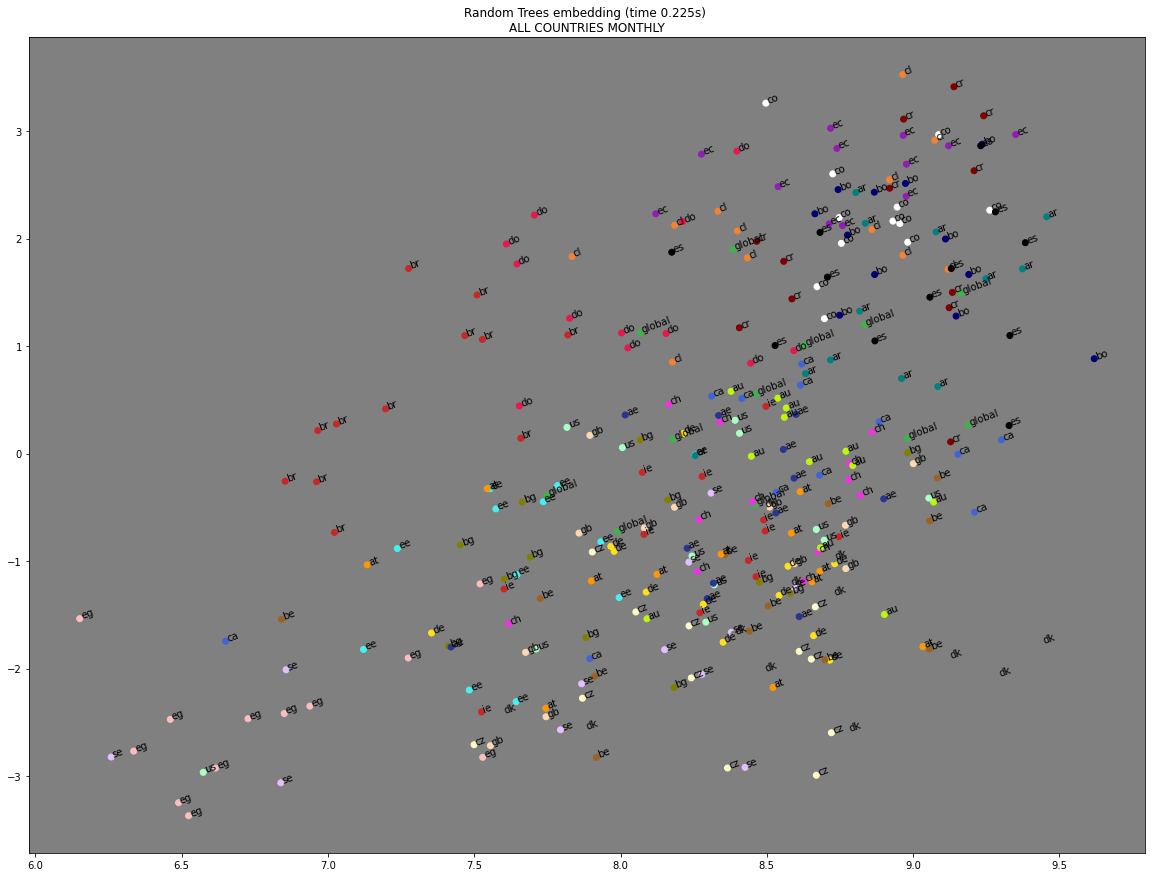

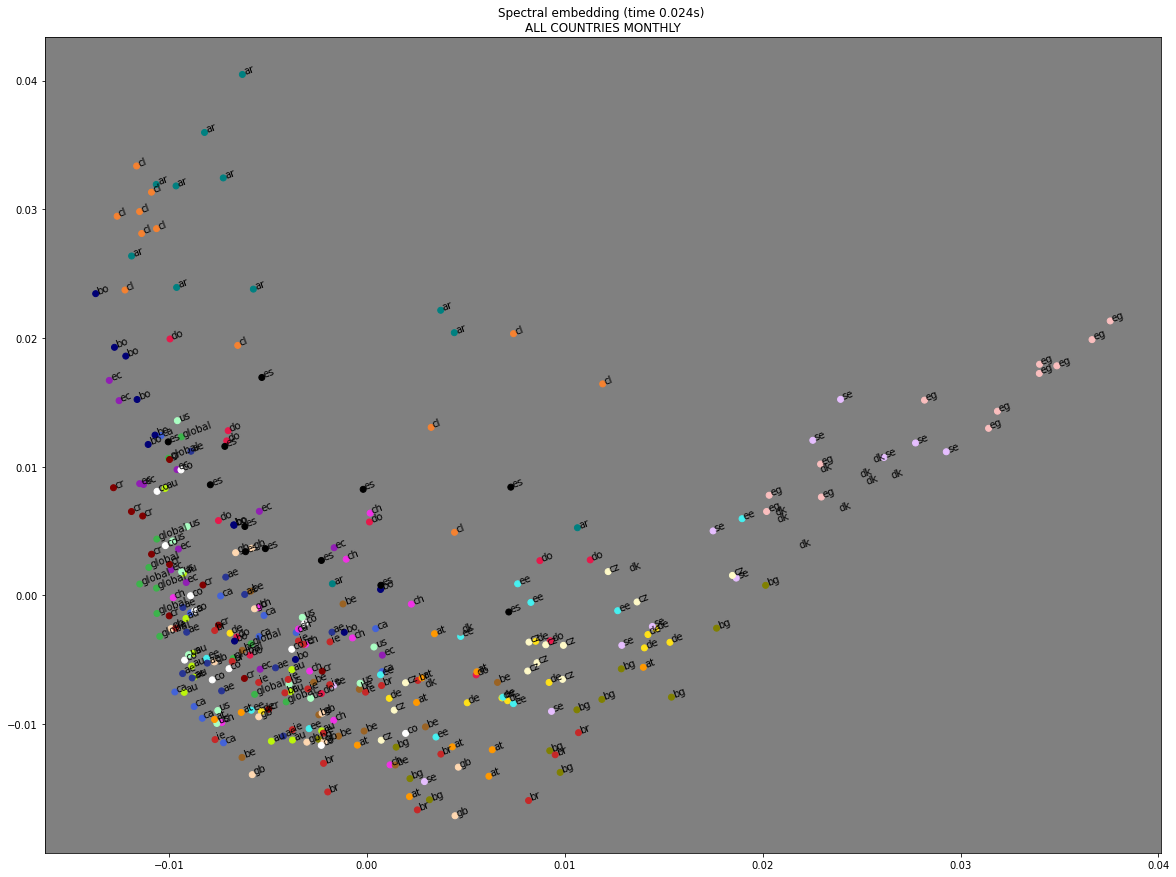

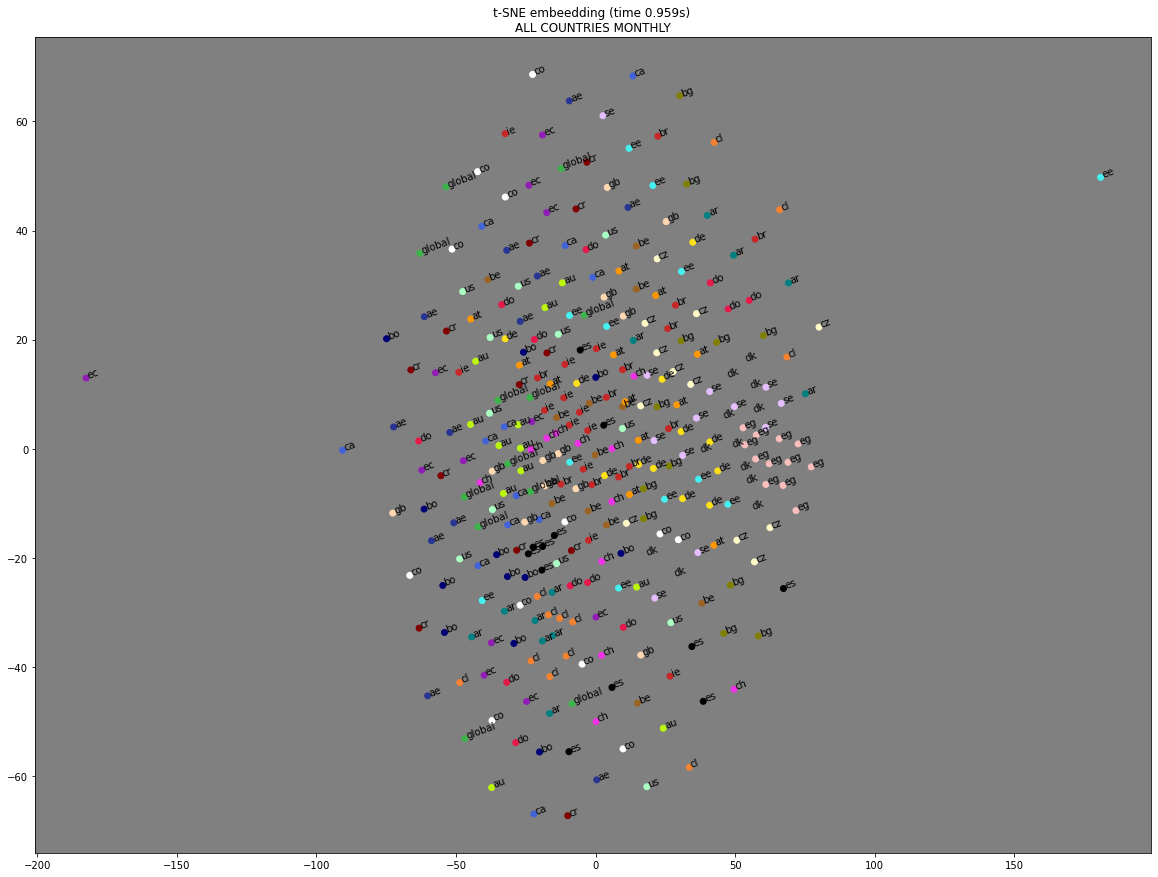

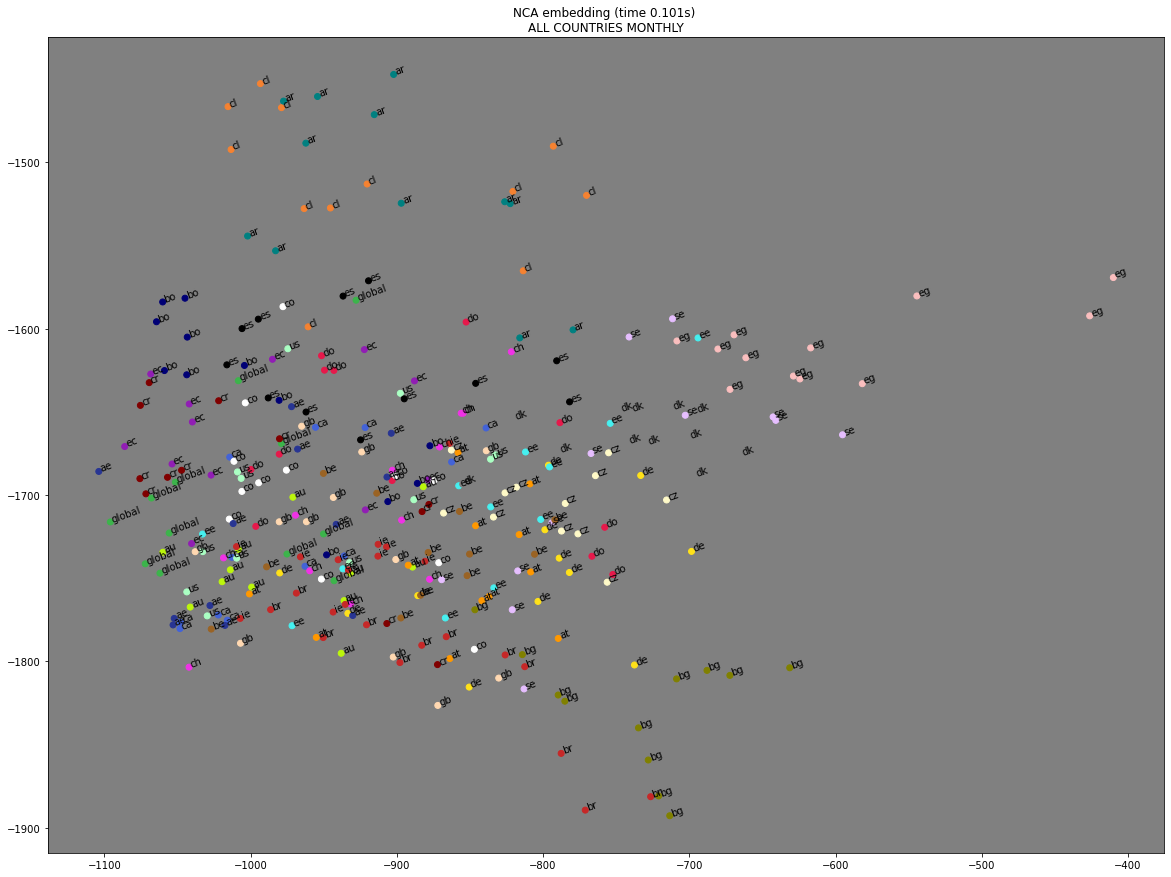

In [626]:
sample_colors, sample_names = zip(*[(constants.COLORS[c], countries[c]) for c in y])
experiment_name = 'ALL COUNTRIES MONTHLY'
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s) \n{experiment_name}"
    plot_func(projections[name], title, sample_colors, sample_names)

plt.show()

/home/aldakata/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


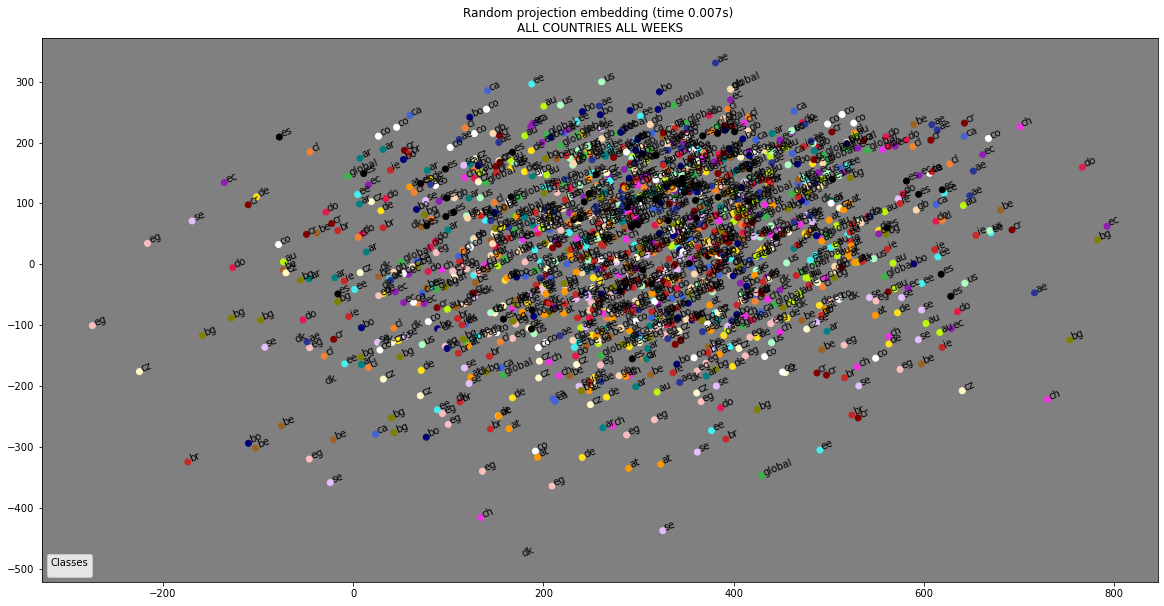

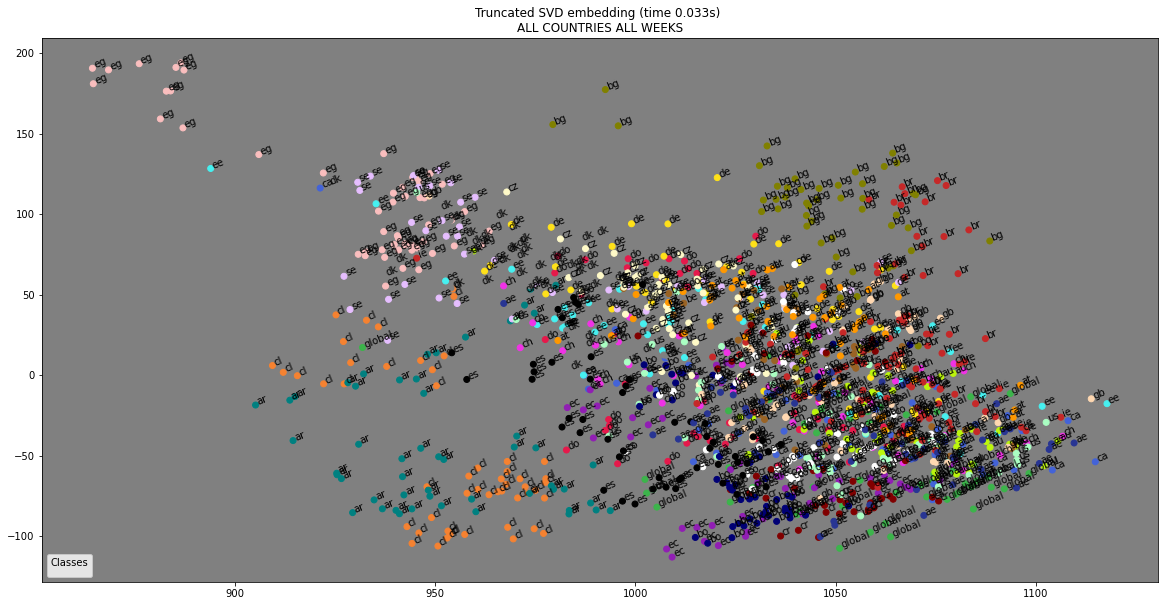

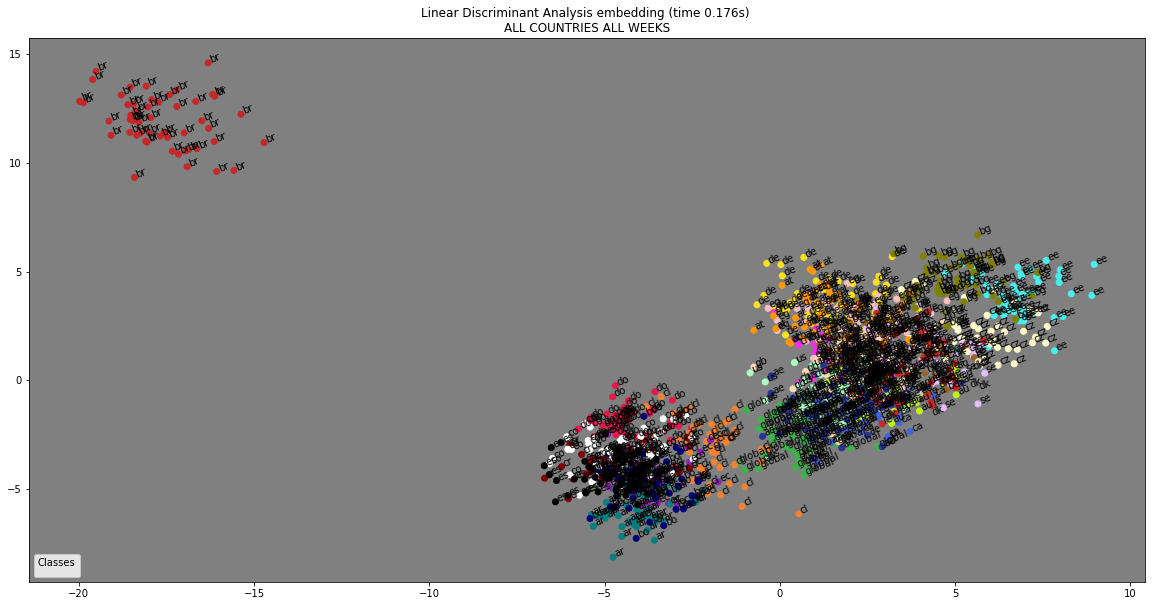

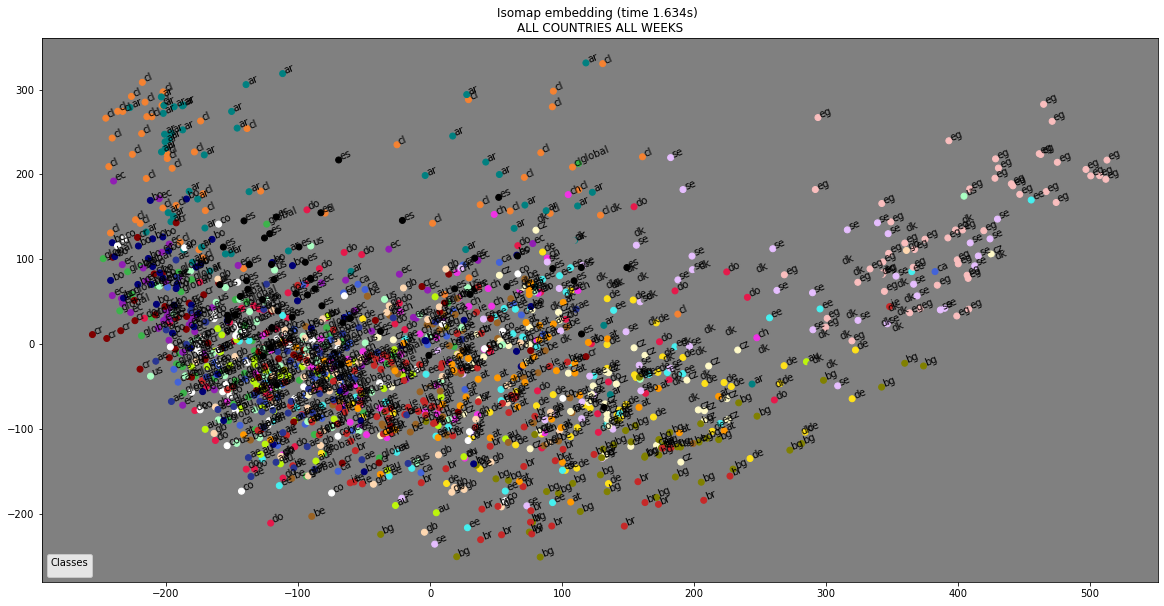

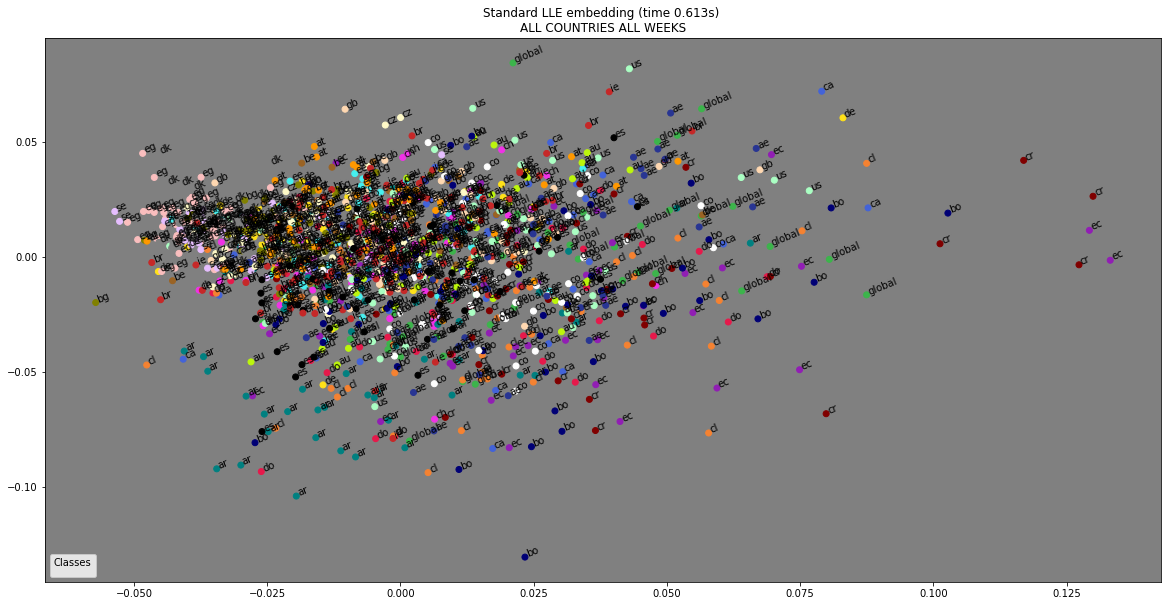

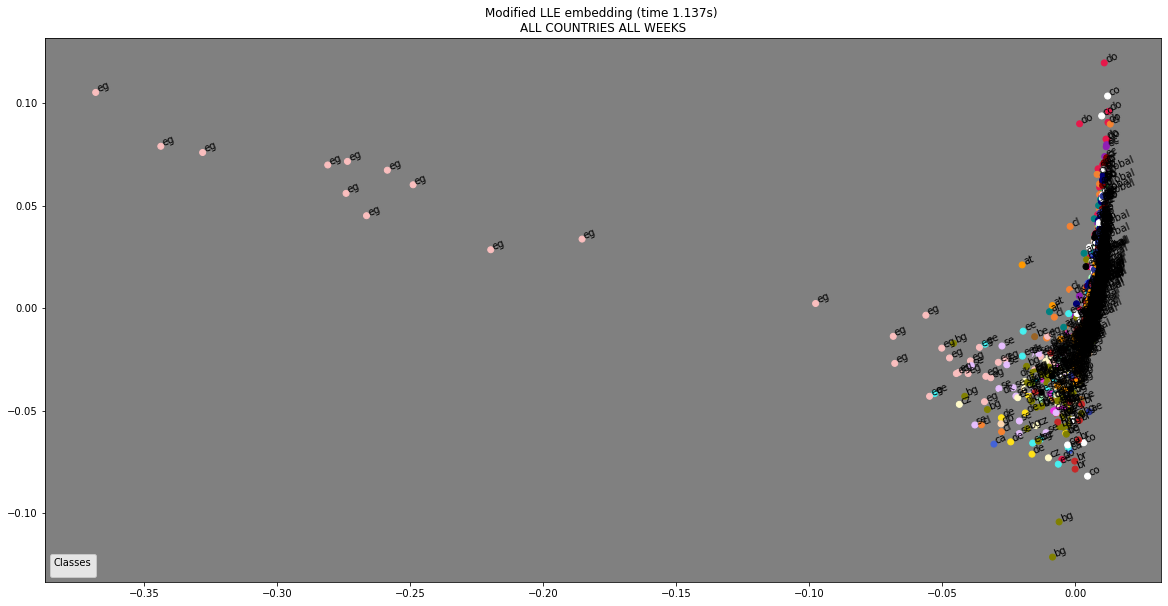

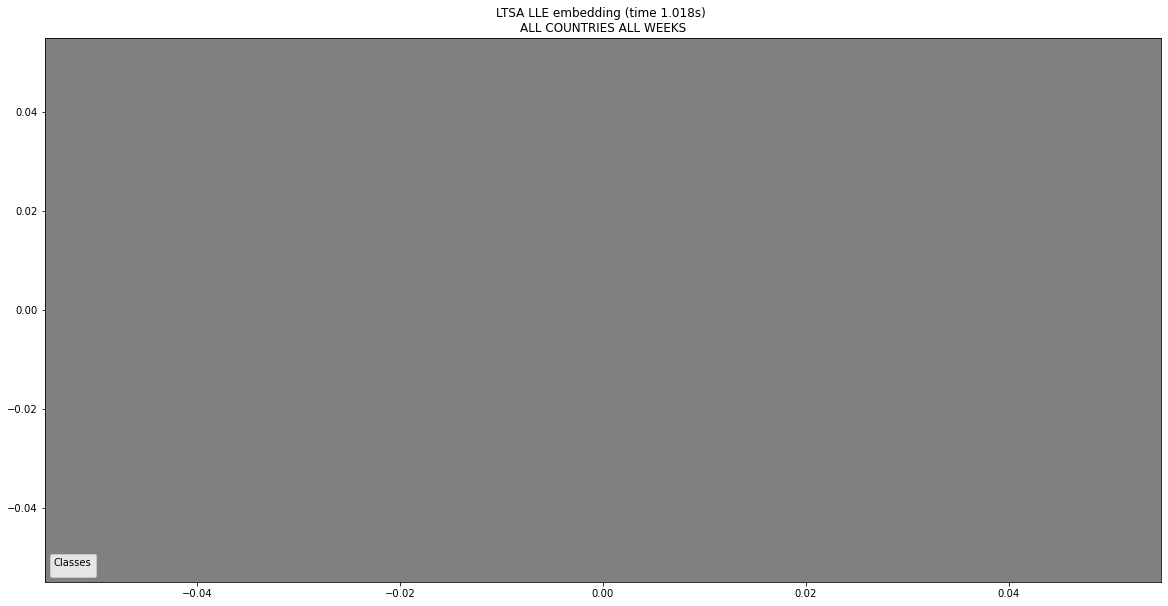

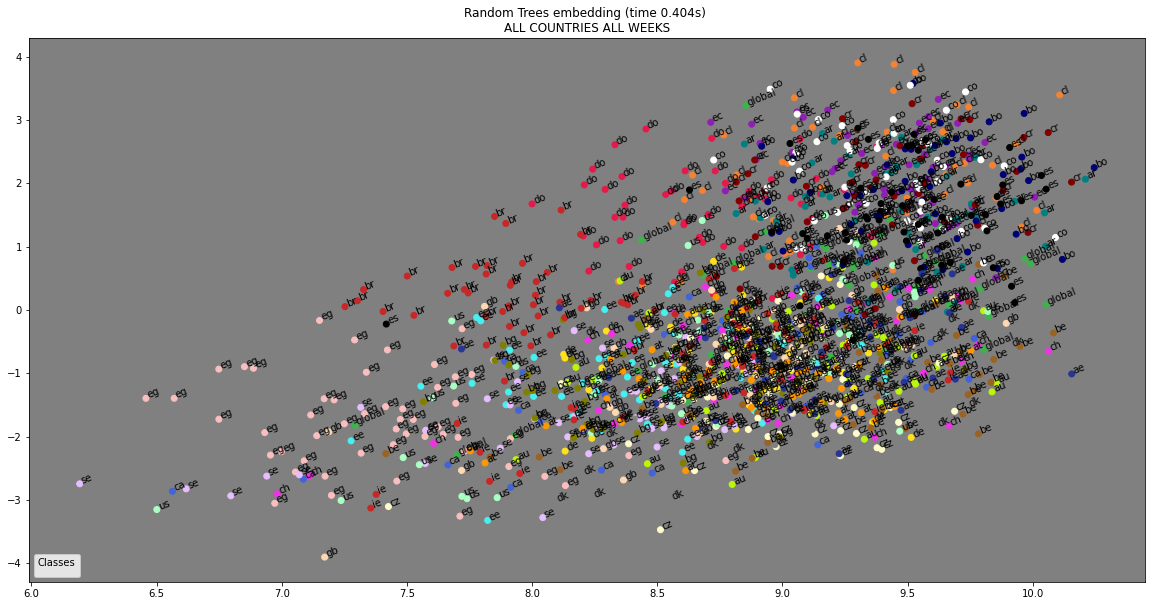

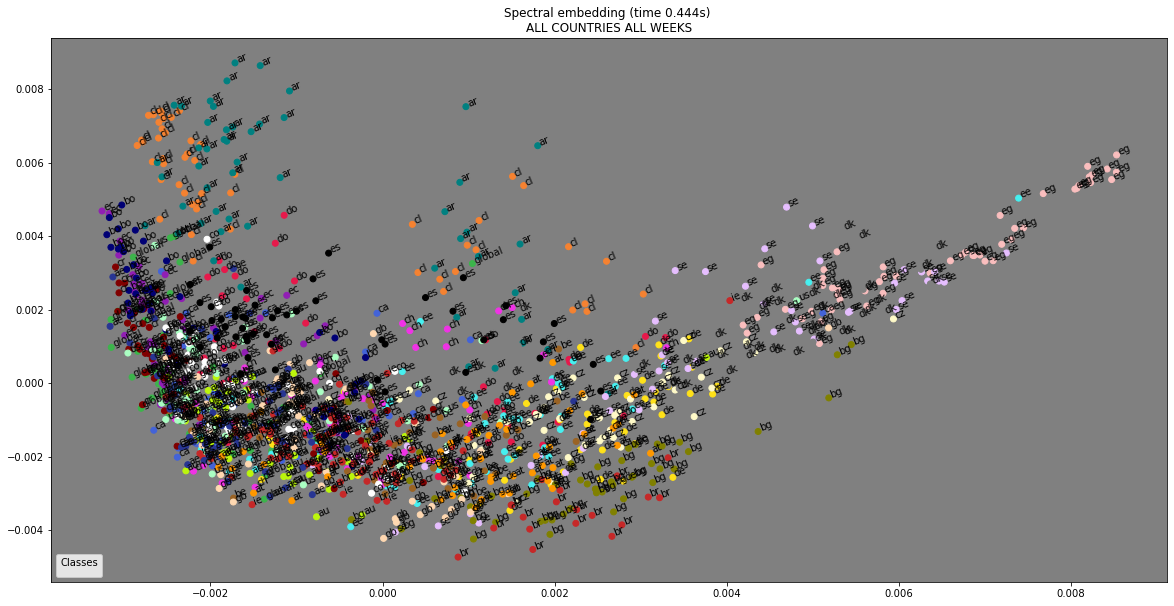

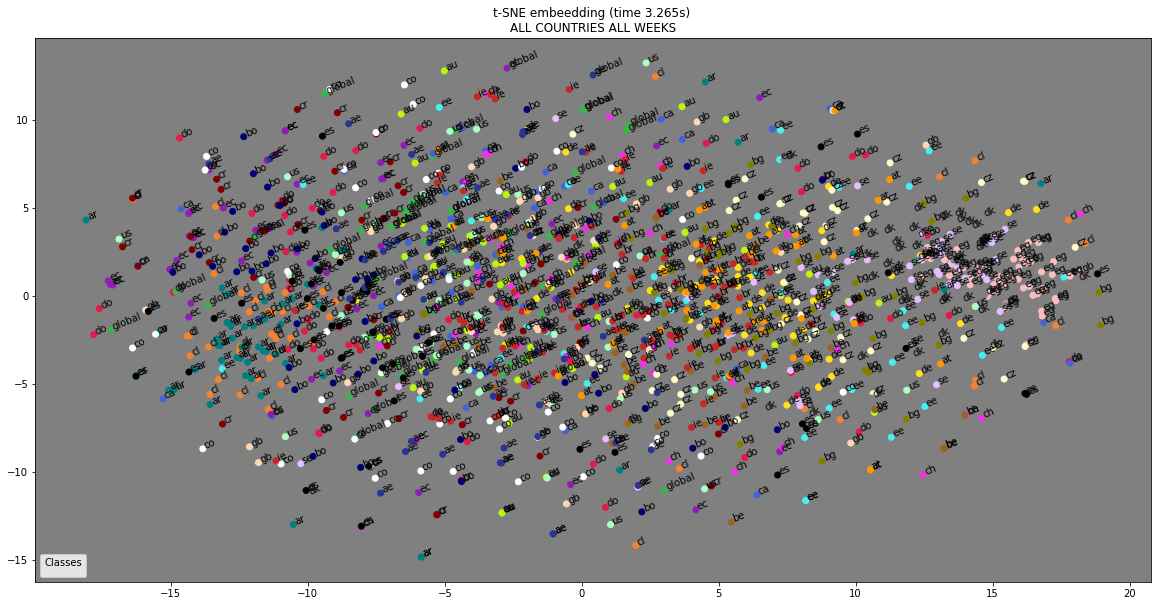

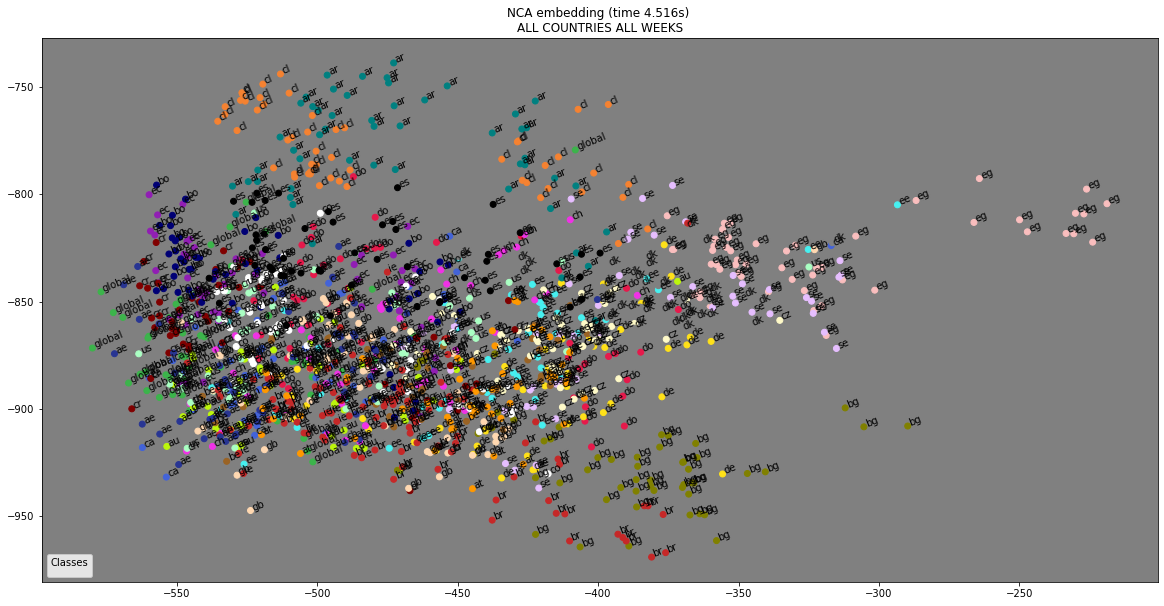

In [545]:
sample_colors, sample_names = zip(*[(constants.COLORS[c], countries[c]) for c in y])
experiment_name = 'ALL COUNTRIES ALL WEEKS'
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s) \n{experiment_name}"
    plot_func(projections[name], title, sample_colors, sample_names)

plt.show()

# Visualisation part

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [253]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [324]:
k,v=constants.country_dict.keys(), constants.country_dict.values()
country_dict_reversed = dict(zip(v,k))


In [325]:
countries_we_care_about = []
for c in countries:
    countries_we_care_about.append(constants.country_dict[c])

In [327]:
world_we_care_about = world[world.name.isin(countries_we_care_about)].reset_index()
world_we_care_about = world_we_care_about.drop(columns='index')

<AxesSubplot:>

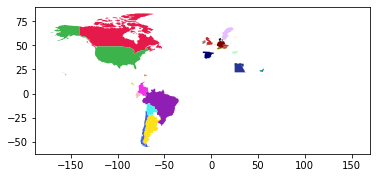

In [335]:
world_we_care_about.plot(color=world_we_care_about['color'])